# Photometric Transient Classification 

**Goals of this tutorial notebook**
1. Introduce the optical-classification problem, anb why astronomers care about early classification.
2. Explore & visualise the light-curve data we will model.
3. Build a simple feature-based photometry classifier that will serve as a baseline for the Transformer Classifier that comes next. 

## Why optical classification?
- Fast, ubiquitous data: Modern wide‑field surveys (ZTF, LSST, etc.) deliver millions of multi‑band light curves every night.
- Cost‑effective follow‑up: Photometry can be obtained with relatively small telescopes and automated pipelines, whereas spectroscopy requires scarce large‑telescope time.

## Why early optical classification?
* Rapid science targets: Some classes (kilonovae, FBOTs) evolve on timescales of hours–days; we must pick them out early.  
* Diverse payoffs: Identify Type Ia SNe early for cosmology, TDEs for SMBH physics, AGN flares for accretion studies, CV outbursts for compact‐binary research, etc.  
* Raw input = multi‑band light curves: Irregularly sampled `(time, flux, error, band)` sequences.  
* Key challenges: Irregular cadence, heteroskedastic errors, class imbalance, and the need for real‑time decisions.


Modern solution → event‐based time‑series models  
We’ll build a **Transformer encoder** (BERT‐style) enhanced with a learnable time embedding to turn each detection into a rich, context‑aware representation for rapid optical classification. 

## Imports & Global Configuration

In [ ]:
#!pip install numpy pandas matplotlib torch torchvision tqdm scikit-learn

In [1]:
import os, math, time, random, itertools, json, warnings
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm

from sklearn.preprocessing import label_binarize
from sklearn.metrics import (average_precision_score, balanced_accuracy_score,
                             top_k_accuracy_score, precision_recall_curve,
                             roc_curve, auc)

warnings.simplefilter("ignore", category=UserWarning)  

# Plotting fluff
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif']
})

# Reproducibility -------------------------------------------------------------
CFG = SimpleNamespace(
    seed           = 42,
    device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # data paths ---------------------------------------------------------------
    root_dir       = Path("data/photo_events"),
    stats_file     = "feature_stats_day100.npz",
    # training knobs -----------------------------------------------------------
    batch_size     = 256,
    num_workers    = 4,
    epochs_pre     = 5,#50,
    epochs_ft      = 160,
    patience       = 30,
    lr_pre         = 5e-4,
    lr_ft          = 2e-4,
    weight_decay   = 1e-2,
    focal_gamma    = 2.0,
    horizon_days   = 100.,
    dropout        = 0.4,
    # model size ---------------------------------------------------------------
    d_model        = 128,
    n_heads        = 8,
    n_layers       = 4,
)

random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
print(f"Running on {CFG.device}")


Running on cuda


## Data-loading utilities and quick exploration

This notebook starts the road of the full pipeline our new Transformer-based photometry classifier, with improved time encoding.  It consists of:

1. Preprocessing Overview (§1): from raw photometry and alerts to a normalized event‐matrix per object.

2. Data Exploration (§1)

3. Implementation of a feature-based classifier.

---

## 1. Preprocessing

We convert raw measurements $(t_i, f_i, \sigma_{f,i})$ into a fixed‐format event sequence $\mathbf X\in\mathbb R^{T\times F}$ for each object.

### 1.1. Merging Simultaneous Observations

To reduce noise and redundant data, any consecutive measurements separated by $\Delta t \le \delta$ (e.g.\ $\delta=12\,$h) are collapsed via inverse‐variance weighting:
$$
w_i = \frac{1}{\sigma_{f,i} + \varepsilon},\quad
\bar t = \frac{\sum_i w_i\,t_i}{\sum_i w_i},\quad
\bar f = \frac{\sum_i w_i\,f_i}{\sum_i w_i},\quad
\overline{\sigma} = \frac{\sum_i w_i\,\sigma_{f,i}}{\sum_i w_i}.
$$
Here $\varepsilon$ guards against zero error.

### 1.2. Feature-Vector Construction

After sorting by Modified Julian Date (MJD), for each event $n$ we compute
$$
\begin{aligned}
\Delta t_n &= \mathrm{MJD}_n - \mathrm{MJD}_1,\\
\delta t_n &= 
\begin{cases}
\mathrm{MJD}_n - \mathrm{MJD}_{n-1}, & n>1,\\
0, & n=1,
\end{cases}\\
\log f_n &= \log_{10}\bigl(\max(f_n,\,10^{-6})\bigr),\\
\sigma_{\log f,n} &= \frac{\sigma_{f,n}}{f_n\,\ln 10},\\
\mathbf b_n &\in\{0,1\}^3\quad\text{(one-hot for filters $g,r,i$)}.
\end{aligned}
$$
We also compute colour indices by nearest‐time matching:
$$
g-r,\quad r-i
$$
and record masks $\mathbf m_n\in\{0,1\}^2$ indicating which colours are valid.  Although colours are computed, the baseline model omits them from the input and uses only
$$
x_n = \bigl[\log(1 + \Delta t_n),\; \log(1 + \delta t_n),\;\log f_n,\;\sigma_{\log f,n},\;\mathbf b_n,\;\mathbf m_n\bigr]\;\in\;\mathbb R^7.
$$

### 1.3. Dataset Splits & Global Normalization

1. Each object’s spectroscopic type is mapped to an integer $y\in\{1,\dots,C\}$, and object IDs are split into train/val/test (70/15/15 %) while preserving class proportions.  
2. We save for each object a compressed file containing its event‐matrix and label, and build manifest_{split}.csv.  
3. Over all training events (total $N$ rows, $F$ features) we compute
$$
\mu_j = \frac{1}{N}\sum_{n=1}^N X_{n,j},\qquad
\sigma_j = \sqrt{\frac{1}{N}\sum_{n=1}^N\bigl(X_{n,j}-\mu_j\bigr)^2}\,,
$$
which are used to normalize the continuous channels. We compute those statistics for light curves under the same truncation as pretraining.

In [2]:
# ===============================================================
#     Taxonomy  -------------------------------------------------
# ===============================================================
# Coarse taxonomy to simplify life
BROAD_CLASSES = ["SNIa", "CC SN", "CV", "AGN", "TDE"]

ORIG2BROAD = {
    # Thermonuclear SNe get their own class (very distinctive light curves)
    "SN Ia": "SNIa",
    # All core-collapse subtypes lumped into one (Ib, Ic, II, IIP, IIn, IIb)
    "SN Ib":   "CC SN",
    "SN Ic":   "CC SN",
    "SN II":   "CC SN",
    "SN IIP":  "CC SN",
    "SN IIn":  "CC SN",
    "SN IIb":  "CC SN",
    # Non-SN proposital-confusion transients kept separate
    "Cataclysmic":               "CV",
    "AGN":                       "AGN",
    "Tidal Disruption Event":    "TDE",
}

NUM_CLASSES  = len(BROAD_CLASSES)
BROAD2ID     = {c:i for i,c in enumerate(BROAD_CLASSES)}

_SUBCLASS_ID2NAME = [
    "SN Ia","SN Ib","SN Ic","SN II","SN IIP","SN IIn","SN IIb",
    "Cataclysmic","AGN","Tidal Disruption Event"
]
ID2BROAD_ID = {
    i: BROAD2ID[ORIG2BROAD[name]]
    for i,name in enumerate(_SUBCLASS_ID2NAME)
}

# ---- one-hot helpers --------------------------------------------------------
_BAND_OH = np.eye(3, dtype=np.float32)   # g,r,i

def build_event_tensor(arr: np.ndarray) -> torch.Tensor:
    """Convert raw [dt, dt_prev, band, logf, logfe] rows → (L,7) tensor."""
    vec4 = np.stack([np.log1p(arr[:,0]),                 # Δt
                     np.log1p(arr[:,1]),                 # δt
                     arr[:,3],                           # log10(flux)
                     arr[:,4]], axis=1)                  # log10(flux_err)
    onehot = _BAND_OH[arr[:,2].astype(int)]
    return torch.from_numpy(np.concatenate([vec4, onehot], axis=1))

class PhotoEventDataset(Dataset):
    """Light-curve fragment truncated at `horizon` days."""
    def __init__(self, manifest_df: pd.DataFrame, horizon: float = np.inf):
        self.df      = manifest_df.reset_index(drop=True)
        self.horizon = horizon
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        data = np.load(row.filepath, allow_pickle=True)
        arr  = data['data'] if isinstance(data, np.lib.npyio.NpzFile) else data
        if self.horizon < np.inf:
            arr = arr[arr[:,0] <= self.horizon]
        #subclass = int(row.label)                # 
        #label    = ID2BROAD_ID[subclass]         # 
        label = int(row.label)
        return build_event_tensor(arr.astype(np.float32)), label

# ---- collate: pad to max-length --------------------------------------------
def load_stats(stats_path):
    st = np.load(stats_path)
    return torch.from_numpy(st['mean']), torch.from_numpy(st['std'])

mean, std = load_stats(CFG.root_dir / CFG.stats_file)
def make_collate(mean, std):
    def collate(batch):
        seqs, labels = zip(*batch)
        Lmax = max(s.shape[0] for s in seqs)
        pad  = torch.zeros(len(seqs), Lmax, 7)
        mask = torch.ones (len(seqs), Lmax, dtype=torch.bool)
        for i,s in enumerate(seqs):
            pad[i,:s.shape[0]] = s
            mask[i,:s.shape[0]] = False
        cont = (pad[...,:4] - mean)/ (std + 1e-8)
        return torch.cat([cont, pad[...,4:]], dim=-1), torch.tensor(labels), mask
    return collate
collate = make_collate(mean, std)

Let's peak at a few light curves to get a feeling of how it differs among our classes!

In [3]:
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

band_styles = {
    0: dict(color='#2A9D8F', marker='o'),  # ztfg
    1: dict(color='#E63946', marker='s'),  # ztfr
    2: dict(color='#F4A261', marker='^'),  # ztfi
}

# plot one input tensor
def plot_tensor_on_ax(ax, tensor):
    # unpack time, flux, flux_err, band
    dt       = np.expm1(tensor[:,0].numpy())     # days since first det.
    flux     = tensor[:,2].numpy()
    flux_err = tensor[:,3].numpy()
    band     = tensor[:,4:7].argmax(1).numpy()
    for b, style in band_styles.items():
        sel = (band == b)
        if not sel.any(): 
            continue
        ax.errorbar(
            dt[sel], flux[sel], yerr=flux_err[sel],
            fmt=style['marker'],
            mfc='none', mec=style['color'],
            ms=4.0, mew=1.4,
            ecolor=style['color'], elinewidth=2.0,
            capsize=4.5
        )
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.minorticks_on()

# assemble a grid of examples
def plot_grid_light_curves(manifest_df, dataset, n_rows=3, random_state=0):
    """
    manifest_df: DataFrame with columns ['filepath','label'] where 'label' is subclass ID (0–9)
    dataset:     PhotoEventDataset(manifest_df, horizon=...)
    n_rows:      how many examples per broad class
    """
    np.random.seed(random_state)
    n_classes = len(BROAD_CLASSES)
    fig, axes = plt.subplots(
        n_rows, n_classes,
        figsize=(4*n_classes, 2.5*n_rows),
        sharex=True, sharey=True, dpi=200
    )
    axes = np.atleast_2d(axes)

    # map each row → its broad‐class ID
    broad_labels = manifest_df['label'].map(ID2BROAD_ID)

    for c, broad_name in enumerate(BROAD_CLASSES):
        # choose indices whose broad label == c
        candidate_idxs = manifest_df.index[broad_labels == c].tolist()
        if len(candidate_idxs) < n_rows:
            raise ValueError(f"Not enough examples for class '{broad_name}'")
        chosen = np.random.choice(candidate_idxs, size=n_rows, replace=False)

        for r, idx in enumerate(chosen):
            ax = axes[r, c]
            tensor, subclass_id = dataset[idx]
            subclass_name = _SUBCLASS_ID2NAME[subclass_id]
            # plot the light curve
            plot_tensor_on_ax(ax, tensor)
            # set combined title
            ax.set_title(f"{subclass_name} ({broad_name})", fontsize=12)
            # y‐axis label on first column of each row
            if c == 0:
                ax.set_ylabel("log(Flux)", fontsize=10)
            # x‐axis label on bottom row
            if r == n_rows - 1:
                ax.set_xlabel("Days since det.", fontsize=10)

    plt.tight_layout()
    plt.show()


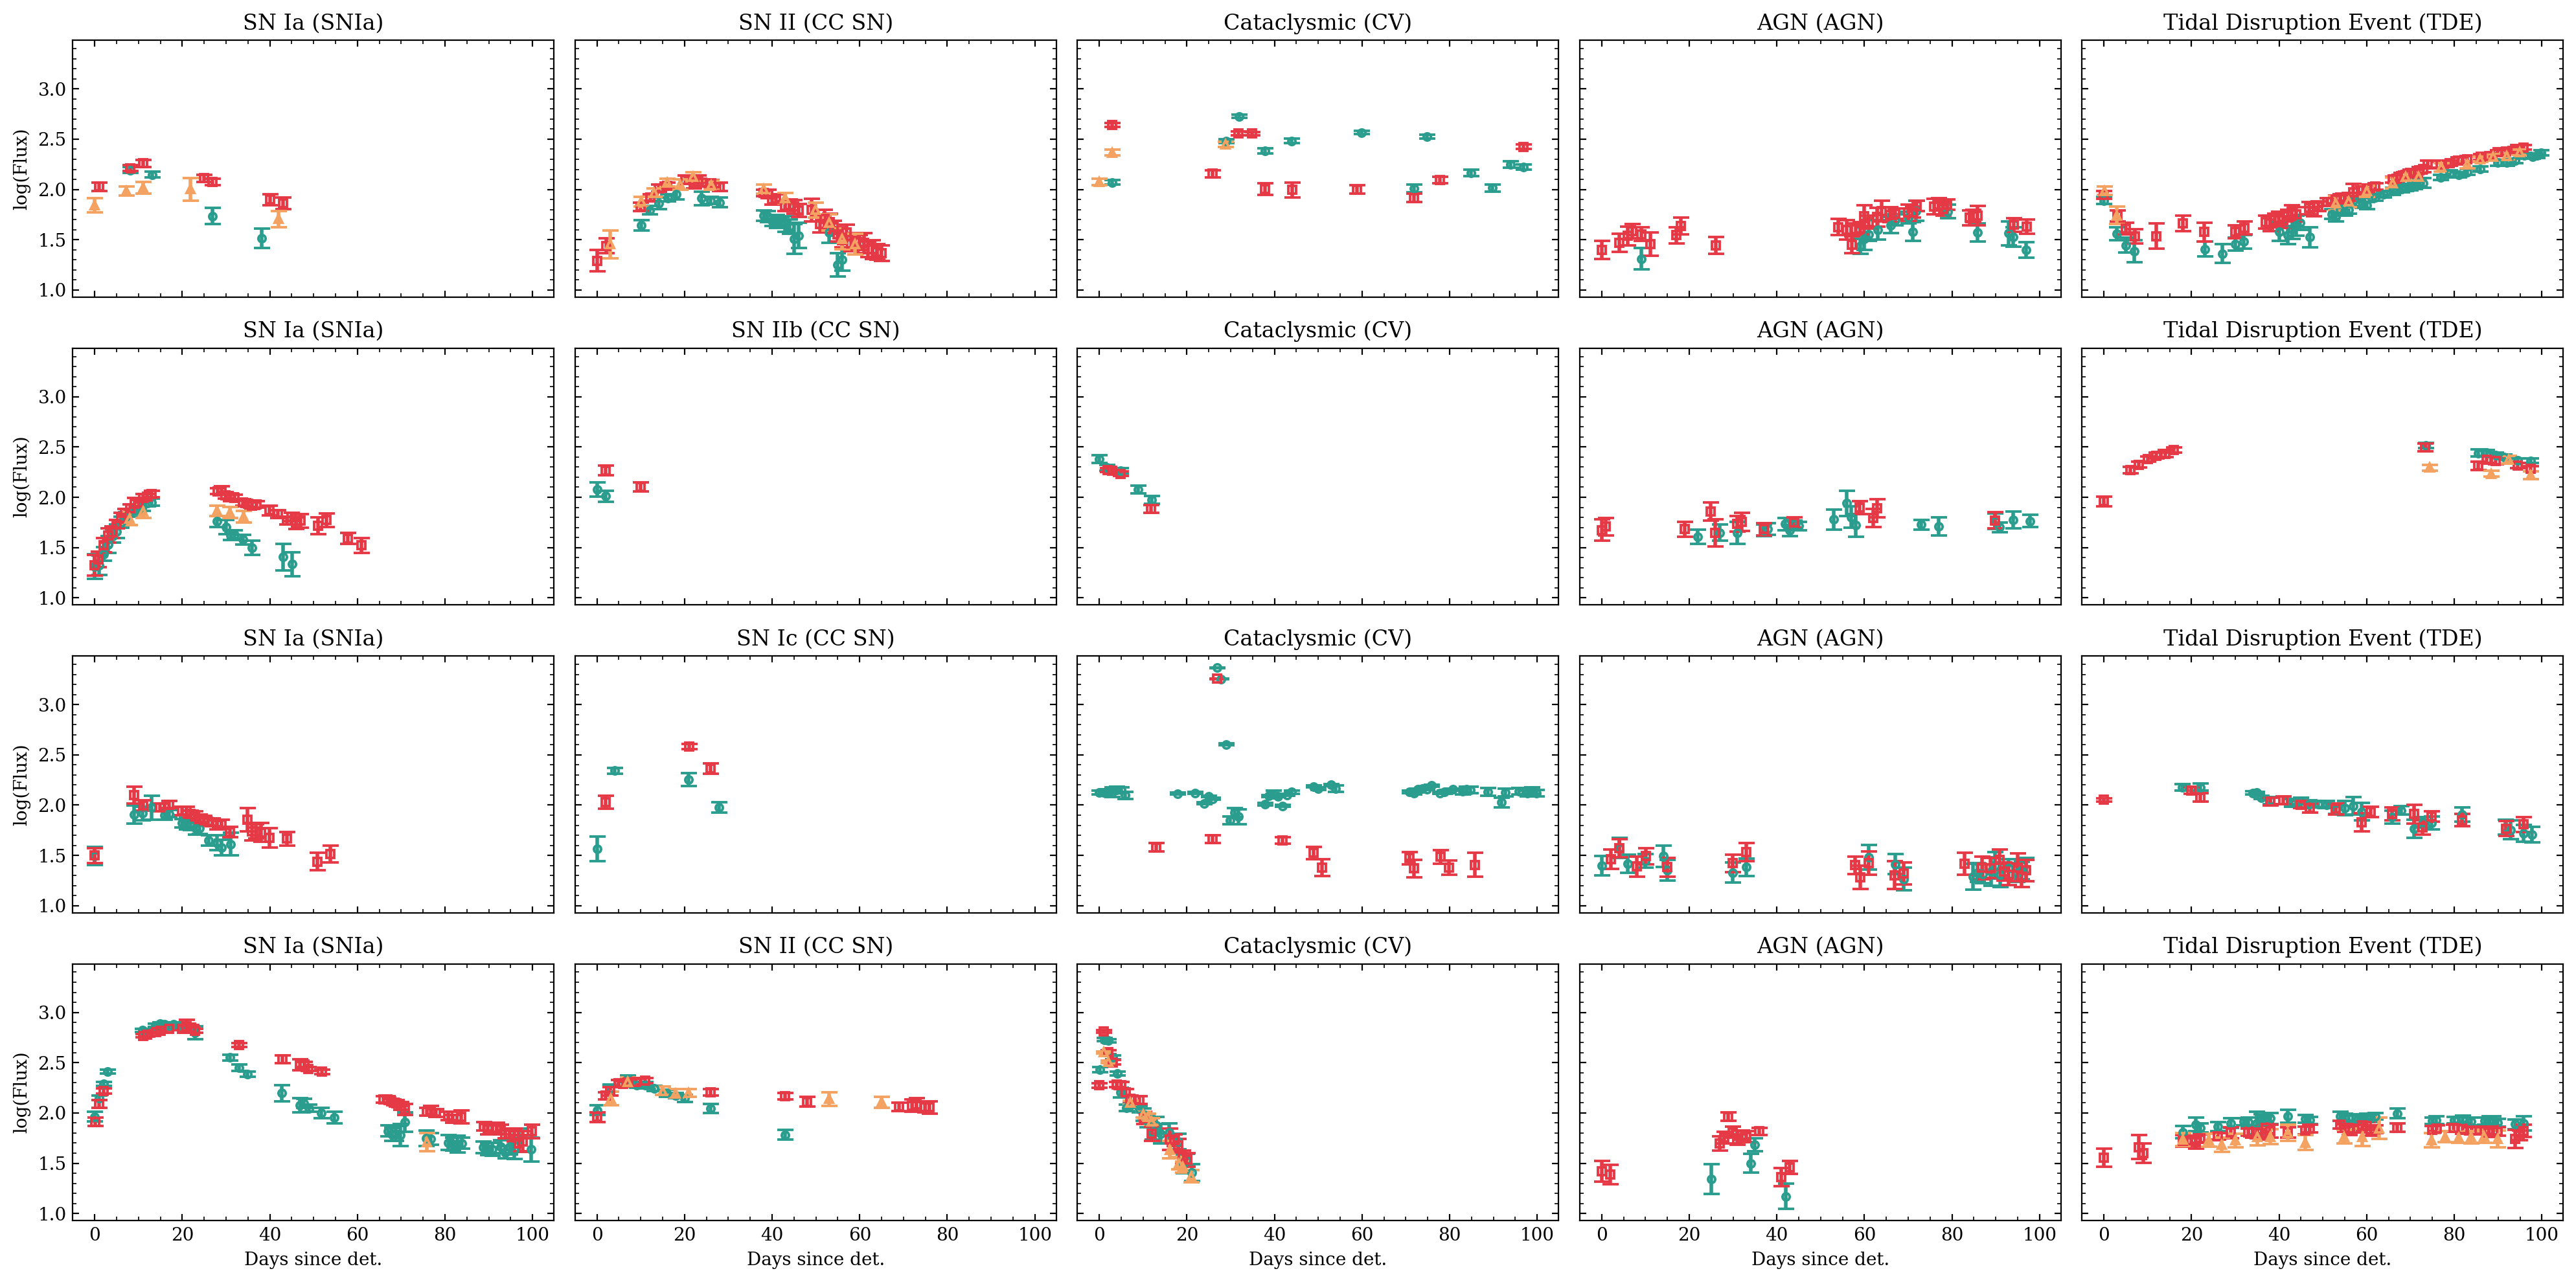

In [4]:
# Plot examples from the training set
manif = pd.read_csv(CFG.root_dir/"manifest_train.csv")
ds    = PhotoEventDataset(manif, horizon=100.)
plot_grid_light_curves(manif, ds, n_rows=4, random_state = 13)

## Exercise 1: Training your wet and rugose birth-given NN as a photometry classifier 

### Don't peak this cell

Why are you peaking this cell? 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tensor(ax, tensor):
    dt       = np.expm1(tensor[:,0].numpy())
    flux     = tensor[:,2].numpy()
    flux_err = tensor[:,3].numpy()
    band     = tensor[:,4:7].argmax(1).numpy()
    for b, style in band_styles.items():
        sel = band == b
        if not sel.any(): continue
        ax.errorbar(
            dt[sel], flux[sel], yerr=flux_err[sel],
            fmt=style['marker'], mfc='none', mec=style['color'],
            ms=4, mew=1.4, ecolor=style['color'], elinewidth=2, capsize=4.5
        )
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.minorticks_on()

def sample_and_plot_mysteries(manifest_df, dataset, n=6, random_state=None):
    """
    Samples n random events from manifest_df/dataset, plots them
    as Mystery 1…n, and **returns** their true subclass & broad labels.
    
    Returns:
      List of dicts, each with keys:
        - 'mystery_id'   : 1…n
        - 'index'        : manifest_df index
        - 'subclass_id'  : integer 0–9
        - 'subclass_name': string, e.g. 'SN II'
        - 'broad_id'     : integer 0–4
        - 'broad_name'   : string, e.g. 'SNcc'
    """
    if random_state is not None:
        np.random.seed(random_state)
    picks = np.random.choice(len(manifest_df), size=n, replace=False)
    
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3), sharey=True, dpi=200)
    axes = np.atleast_1d(axes)
    
    results = []
    for i, idx in enumerate(picks):
        ax = axes[i]
        tensor, subclass_id = dataset[idx]
        broad_id    = ID2BROAD_ID[subclass_id]
        subclass_nm = _SUBCLASS_ID2NAME[subclass_id]
        broad_nm    = BROAD_CLASSES[broad_id]
        
        # plot & label
        plot_tensor(ax, tensor)
        ax.set_title(f"Mystery {i+1}", fontsize=12)
        if i == 0:
            ax.set_ylabel("log(Flux)", fontsize=10)
        ax.set_xlabel("Days since first det.", fontsize=10)
        
        results.append({
            'mystery_id':    i+1,
            'index':         int(idx),
            'subclass_id':   int(subclass_id),
            'subclass_name': subclass_nm,
            'broad_id':      int(broad_id),
            'broad_name':    broad_nm
        })
    
    plt.tight_layout()
    plt.show()
    
    return results

In [6]:
manif = pd.read_csv(CFG.root_dir/"manifest_train.csv")
ds    = PhotoEventDataset(manif, horizon=100.)

### Mystery light curves
**Objective:** Train your eye to recognize broad transient classes from photometric light curves.

---

### a) Training

1. **Generate labelled light curves**  
   Use and adapt the provided `plot_grid_light_curves(...)` function to display light curves with their corresponding spectroscopic labels as well as the broad labels we're interested in.  
   - Try different values of `N` (e.g. 6, 8, 10) to get more or fewer examples.  
   - Note the shape, rise/decay times, and how the g/r/i filters interleave.

2. **Study & Discuss**  
   - **Study** the rise times, decay slopes, scatter, and relative brightness in each filter.  
   - **Discuss with your peers** around you:  
     - What visual features help you separate **Type Ia Supernova (SN Ia)**, **Core Collapse Supernova (CC SN)**, **Cataclysmic Variable (CV)**, **Active Galactic Nucleus (AGN)**, **Tidal Disruption Event (TDE)**. ?  
     - Come to a consensus on the “signature” light‐curve hallmarks of each class.

---

### b) Classification Challenge

Below are **Mystery Light Curves #1…#M** for you to classify:

1. **Assign a class** to each mystery curve:
   - Choose one of: **Type Ia Supernova**, **Core Collapse Supernova**, **Cataclysmic Variable**, **Active Galactic Nucleus**, **Tidal Disruption Event**.  
2. **Justify your choice** in a few bullet-points:
   - Which features (rise/decay rate, filter ordering, amplitude differences) guided your decision?  
3. **Peer review**  
   - Share your classifications with your peers around you.  
   - Discuss any disagreements and refine your criteria together.

---

> **Tip:** The more light curves you examine, the sharper your classification intuition will become. Good luck! 


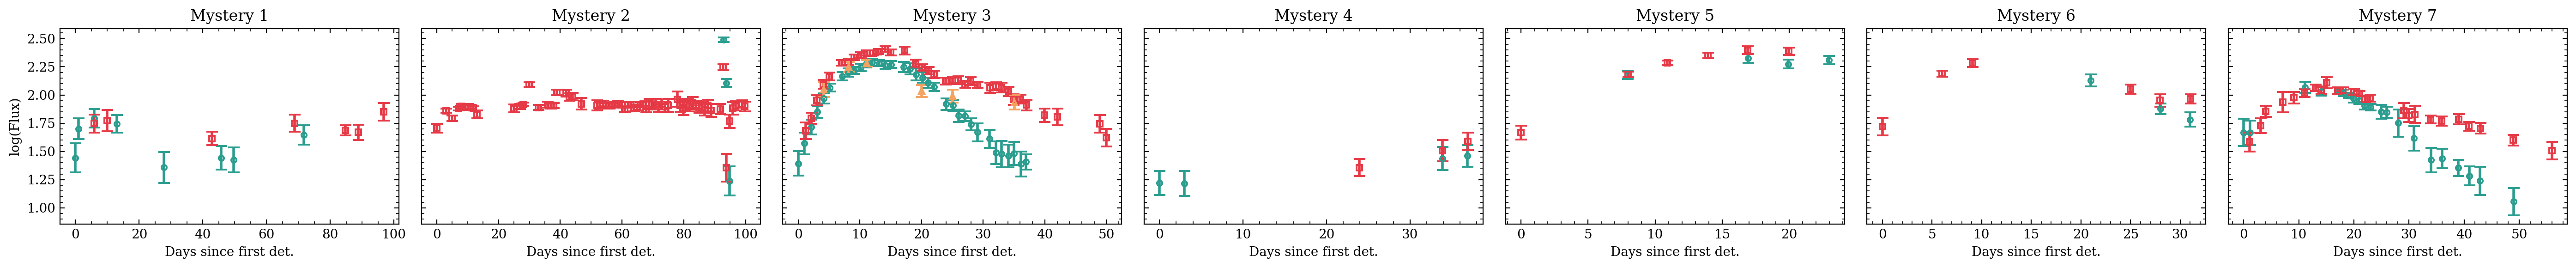

In [7]:
# show 7 mystery curves
answers = mystery_info = sample_and_plot_mysteries(manif, ds, n=7, random_state=1338)

## Exercise 1: Solution 

In [8]:
for info in answers:
    print(f"Mystery {info['mystery_id']}: "
          f"{info['subclass_name']} ({info['broad_name']})")

Mystery 1: AGN (AGN)
Mystery 2: Cataclysmic (CV)
Mystery 3: SN Ia (SNIa)
Mystery 4: AGN (AGN)
Mystery 5: SN Ib (CC SN)
Mystery 6: SN Ia (SNIa)
Mystery 7: SN Ia (SNIa)


### But why? 
Now that you know the answers, discuss with your peers:

- Which cases were the easiest or hardest to classify?  
- What specific light‐curve features (rise time, plateau length, color ordering) helped you most?  
- How might noise or sparse sampling lead to misclassification?

### Exercise 2: Feature based classifier!

Working in small teams, evaluate the Mystery light curves you just plotted to build a “classical” feature‑based classifier from scratch (no deep learning). Extract a handful of intuitive summary statistics from each light curve (e.g. number of detections, mean and max flux, time of peak, simple decline rate) and then train a scikit‑learn model to predict the broad class (`SNIa`, `CC SN`, `CV`, `AGN`, `TDE`). Discuss your chosen features and any misclassifications with your peers.

**Tasks**  
a) Write a feature‐extraction function that computes at least 4 summary stats per event.  
b) Fit a `RandomForestClassifier` (or `LogisticRegression`) on the training set.  
c) Print a classification report and discuss which classes are easiest/hardest.


### Suggested Features for Your Classifier

- **Flux statistics**  
  - `mean_flux`, `std_flux`, `max_flux`, `min_flux`  
  - `flux_amplitude = max_flux - min_flux`  
  - `median_flux`, interquartile range (IQR)

- **Timing features**  
  - `N_detections`  
  - `t_first`, `t_last`  
  - `rise_time = t_peak - t_first`  
  - `decline_rate = (flux_last - flux_peak) / (t_last - t_peak)`

- **Shape & variability**  
  - `pre_peak_slope`, `post_peak_slope` (linear fits)  
  - `flux_skewness`, `flux_kurtosis`

- **Color proxies**  
  - `mean_flux_g - mean_flux_r`, `mean_flux_r - mean_flux_i`  
  - `peak_color` at time of maximum flux

- **Cadence metrics**  
  - `mean_dt` (average Δt between detections)  
  - `max_gap` (largest Δt)

---

### Tip: 

All of the true subclass & broad‑class labels live in the manifest CSVs (`manifest_train.csv`, etc.) under the `label` column. You can map them like this:

The full header of the manifest contains: `obj_id,filepath,label,n_events,split`
```python
import pandas as pd
from your_notebook import _SUBCLASS_ID2NAME, ID2BROAD_ID, BROAD_CLASSES

df = pd.read_csv("data/photo_events/manifest_train.csv")
for idx, row in df.iterrows():
    subclass_id   = int(row["label"])                # 0–9
    subclass_name = _SUBCLASS_ID2NAME[subclass_id]   # e.g. "SN Ia"
    broad_id      = ID2BROAD_ID[subclass_id]         # 0–4
    broad_name    = BROAD_CLASSES[broad_id]          # e.g. "SNIa"
    # use subclass_id or broad_id as your y‐labels in scikit‑learn


## Exercise 2: Solution

## Exercise 3: How did the training go?

```history['train']``` and ```history['val']``` are lists of ```(loss, acc)```. 

* a) Make a plot of their evolution through the training epochs.
* b) Evaluate the training performance. Did you model underfit or overfit? Why do you think so? If yes, what strategies could you implement to set the training along the sweet spot?
* c) Given the severe imbalance in our dataset, what other metrics can you plot to further evaluate the evolution of the model's classification capacity?

In [ ]:
# --- training curves ---------------------------------------------------------

# history['train'] and history['val'] are lists of (loss, acc)
tr = np.array(history['train'])
va = np.array(history['val'])

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), dpi=300)

# COMPLETE THE CODE HERE!

plt.tight_layout()
plt.show()

## Exercise 3: Solution

In [ ]:
# --- training curves ---------------------------------------------------------

# history['train'] and history['val'] are lists of (loss, acc)
tr = np.array(history['train'])
va = np.array(history['val'])

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), dpi=300)

# ─── Loss ────────────────────────────────────────────────────────────────
axes[0].plot(tr[:, 0], label="train", color='black')
axes[0].plot(va[:, 0], label="val",   color='tomato')
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].tick_params(direction='in', which='both', top=True, right=True)
axes[0].minorticks_on()

# ─── Accuracy ────────────────────────────────────────────────────────────
axes[1].plot(tr[:, 1], label="train", color='black')
axes[1].plot(va[:, 1], label="val",   color='tomato')
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].tick_params(direction='in', which='both', top=True, right=True)
axes[1].minorticks_on()

plt.tight_layout()
plt.show()

## Exercise 4 Model performance on _Test Set_

Evaluate the model using your favorite metrics.

In [ ]:
# --- per-class ROC & PR at full horizon --------------------------------------

from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# collect predictions & labels on CPU
y_true = []
y_prob = []
model.eval()
with torch.no_grad():
    for x, y, m in ld_test:
        x, y, m = x.to(CFG.device), y.to(CFG.device), m.to(CFG.device)
        logits = model(x, m)
        y_true.append(y.cpu())
        y_prob.append(torch.softmax(logits, dim=1).detach().cpu())

y_true = torch.cat(y_true).numpy()
y_prob = torch.cat(y_prob).numpy()
y_one  = label_binarize(y_true, classes=np.arange(NUM_CLASSES))

# plot ROC & Precision‑Recall
fig, axes = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

for c, cls in enumerate(BROAD_CLASSES):
    fpr, tpr, _ = roc_curve(y_one[:, c], y_prob[:, c])
    rec, prc, _ = precision_recall_curve(y_one[:, c], y_prob[:, c])
    axes[0].plot(fpr, tpr, label=cls)
    axes[1].plot(rec, prc, label=cls)

# diagonal for ROC
axes[0].plot([0, 1], [0, 1], 'k--')

# labels & titles
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC")

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision‑Recall")

# ticks & grid
for ax in axes:
    ax.legend()
    ax.grid(alpha=0.3)
    ax.tick_params(direction='in', which='both', top=True, right=True)
    ax.minorticks_on()

plt.tight_layout()
plt.show()